# Problem sheet 2 (Group 33)


In [19]:
#set up stuff 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def remove_outliers(df,lq=0,hq=1):
    #df: Dataframe with only the variables to trim
    # lq: lowest quantile. hq:Highest quantile
    columns = pd.Series(df.columns.values).tolist()
    for serie in columns:
        df["houtliers_"+serie] = df[serie].quantile(hq)
        df[df[serie]>df["houtliers_"+serie]] = np.nan
        df["loutliers_"+serie] = df[serie].quantile(lq)
        df[df[serie]<df["loutliers_"+serie]]= np.nan
        del df["houtliers_"+serie], df["loutliers_"+serie]
    return df


def gini(array):
    # from: https://github.com/oliviaguest/gini
    #http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm 
    array = np.array(array)
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array += np.amin(array) #non-negative
    array += 0.0000001 #non-0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) 
    n = array.shape[0]
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) 


def data_stats(data, percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]):
    ### Compute mean, sd, min, max, quintiles and Gini of the states in the state list.
    # Inputs -----------------
    # Dataframe
    
    #Obtain the describtive statistics for the state variables.    
        
    summary = data.describe(percentiles)
    summary.reset_index(inplace=True)
        
    #Generate Gini statistic:
    gini_stat = np.empty(len(data.columns)).reshape(1,len(data.columns))
    
    for i, var in enumerate(data.columns):
        gini_stat[:,i] = gini(data[var].dropna())
                
    data_gini = pd.DataFrame(gini_stat, columns=data.columns)    
    data_gini.reset_index(inplace=True)
    data_gini['index'] = 'Gini'
    summary = summary.append(data_gini, ignore_index=True)
    summary.set_index('index', inplace=True)
    
    return summary


def plot_cond_log_distr(data, variable1, variable2, save=False):
        fig, ax = plt.subplots()
        a = data[variable2].unique()
        for value in a:           
            sns.distplot((np.log(data.loc[data[variable2] == value][variable1]).replace([-np.inf, np.inf], np.nan)).dropna()-np.mean((np.log(data[variable1]).replace([-np.inf, np.inf], np.nan)).dropna()), label=variable2+str(value))
           
        plt.title('Distribution of '+variable1+' in Uganda')
        plt.xlabel(variable1)
        ax.legend()
        
        return plt.show()
        
def plot_cum_cond_log_distr(data, variable1, variable2, save=False):
        fig, ax = plt.subplots()
        a = data[variable2].unique()
        for value in a:           
            sns.distplot((np.log(data.loc[data[variable2] == value][variable1]).replace([-np.inf, np.inf], np.nan)).dropna()-np.mean((np.log(data[variable1]).replace([-np.inf, np.inf], np.nan)).dropna()), label=variable2+str(value), hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
        plt.title('Cumulative Distribution of '+variable1+' in Uganda')
        plt.xlabel(variable1)
        ax.legend()
        return plt.show()       




# Exercise 1 
### 1a) 

In [20]:
#import data
df1 = pd.read_excel("UNPS_1112_PS2.xls")

#1a
#count number of duplicates in column hhid 
print("the number of duplicates is ",df1.hhid.duplicated().sum() )

print("there are ", len(df1["hhid"]), "observations.")


the number of duplicates is  0
there are  2613 observations.


### 1b) 
Present some basic summary statistics for the following variables: head_gender, head _age, familysize, consumption, income, wealth. Comment your results in 2 lines. In particular, you might mention if there are missing observations or potential outliers for some of the variables.

- head_gender	gender of the household head: 1 if male, 2 if female.
- head_age	age of the household head 
- consumption	total household consumption (excluding durables). In 2013 dollars, adjusted for inflation.
- income -total household income. In 2013 dollars, adjusted for inflation.
- wealth - total household wealth. In 2013 dollars, adjusted for inflation.




In [21]:
#summary statistics 
df1[['head_gender','head_age','income','wealth','familysize','consumption']].describe()

,head_gender,head_age,income,wealth,familysize,consumption
count,2597.000000,2597.000000,2613.000000,2613.000000,2597.000000,2613.000000
mean,1.314209,46.068156,1860.075795,4912.698146,7.480554,1803.792687
std,0.464289,15.068960,2607.517603,8359.886497,3.712526,1308.742941
min,1.000000,14.000000,27.486921,0.000000,1.000000,250.305506
25%,1.000000,34.000000,471.204368,720.019916,5.000000,918.324958
50%,1.000000,44.000000,1061.194208,2108.598380,7.000000,1426.614855
75%,2.000000,56.000000,2234.800590,5221.939857,9.000000,2296.859516
max,2.000000,100.000000,52137.736864,76396.339917,33.000000,8369.898484


In [22]:
#Checking for na values
print('number of NA values')
print(df1[['head_gender','head_age','income','wealth','consumption']].isna().sum())
#from the observation there are null values for head_gender and head_age 
#for a more accurate representation of gender statistics we will remove the corresponding rows from the dataframe

#drop rows with NaNs corresponding to the 2 above (for a more accurate representation of gender
#  statistics we will remove the corresponding rows from the dataframe)


df1.dropna(subset=['head_gender', 'head_age'], inplace=True)

#check the number of outliers 
#we define an outlier to be an observation more than 3 s.d
#from the mean 
print("\n", 'number of outliers:')
col = ['head_gender','head_age','income','wealth','consumption']
for i in col:
    mean = df1[i].mean()
    sd = df1[i].std()
    outlier = df1[i] > mean+(3*sd) 
    sum_outliers = outlier.sum()
    
    print('for column: {}'.format(i))
    print("the number of outliers are", sum_outliers, "\n")
    



number of NA values
head_gender    16
head_age       16
income          0
wealth          0
consumption     0
dtype: int64

 number of outliers:
for column: head_gender
the number of outliers are 0 

for column: head_age
the number of outliers are 5 

for column: income
the number of outliers are 50 

for column: wealth
the number of outliers are 62 

for column: consumption
the number of outliers are 57 



In [23]:
#we can also clean the dataframe of possible outliers 
#remove outliers that lie more 
#than 3 standard deviations away from the mean

# col = ['head_age','income','wealth','consumption']
# for i in col:
#     mean = df1[i].mean()
#     sd = df1[i].std()
#     df1 = df1[(df1[i] <= mean+(3*sd))] 
    
# #this returns a dataframe with the outliers removed
#however since we have limited of the data set,we have chosen not to. 


In [24]:
#after cleaning we apply the previous summary statisitcs:

df1[['head_gender','head_age','income','wealth','familysize','consumption']].describe()

,head_gender,head_age,income,wealth,familysize,consumption
count,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000,2597.000000
mean,1.314209,46.068156,1858.913999,4899.744717,7.480554,1802.456731
std,0.464289,15.068960,2606.619269,8274.000294,3.712526,1304.838441
min,1.000000,14.000000,27.486921,0.000000,1.000000,250.305506
25%,1.000000,34.000000,471.344690,720.019916,5.000000,919.372079
50%,1.000000,44.000000,1065.445435,2113.997327,7.000000,1426.527595
75%,2.000000,56.000000,2234.800590,5233.250057,9.000000,2298.430197
max,2.000000,100.000000,52137.736864,76396.339917,33.000000,8369.898484


mean income and mean consumption is almost equal,thus most of their income is spent on consumption which may be attributed to the large family size or imply subsistence farming. Household wealth is high but also has a large standard deviation of (~8000), which shows some evidence of wealth disparity.

### 1c

Using the head_gender variable, create a dummy variable for household head being female (1=female, 0=male). Be careful with missing values. What is the proportion of households where the head is female?

In [25]:
#previously we have removed missing values from the 
#data frame

#generate female dummy variable column , the output 

female = pd.get_dummies(df1['head_gender'])

# remove column corresponding to male == 1 
female = female.drop([1.0],axis = 1) 


proportion = female.mean()
print('proportion of females =', proportion) 

#rename column 2.0 to female and concatate to df1
female.rename(columns={2.0:'female'}, inplace=True)
df1 = pd.concat([df1, female], axis=1)


proportion of females = 2.0    0.314209
dtype: float64


### 1d 



In [26]:

gender_stats = df1[['head_gender','head_age','income','wealth','consumption']].groupby(by='head_gender').mean()
gender_stats.rename(index={1.0: 'male ', 2.0: 'female '}, inplace=True)
print(gender_stats)


              head_age       income       wealth  consumption
head_gender                                                  
male         44.388546  2061.184846  5278.582949  1898.303754
female       49.734069  1417.438044  4072.893135  1593.261206


We do observe differences between the two sets of households. The differences are definitely noticeable between the two groups, with households with a female head having approximately 75 percent of the wealth of those with male heads, and similarly sized disparities in wealth. Consumption is slightly more similar between the two groups, however household consumption for the average female led household is still lower. On average, female household leaders were 5 years older than male ones.

# Exercise 2 

In [27]:
# Exercise 2

l1 = ['consumption','income','wealth']
#checking NAs and zeros in wealth 
for i in l1:
    print("number of NAs in ",i,df1[i].isna().sum())
    num_zeros = (df1[i] == 0).sum()
    print("Number of zeros in ",i, num_zeros, "\n")

#to avoid infinity values when we log, we will 

#remove rows with zeros in wealth column so there are no infinity values (when applying logs)
df1 = df1[df1["wealth"] != 0]

number of NAs in  consumption 0
Number of zeros in  consumption 0 

number of NAs in  income 0
Number of zeros in  income 0 

number of NAs in  wealth 0
Number of zeros in  wealth 15 



C:\Users\arifs\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\arifs\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


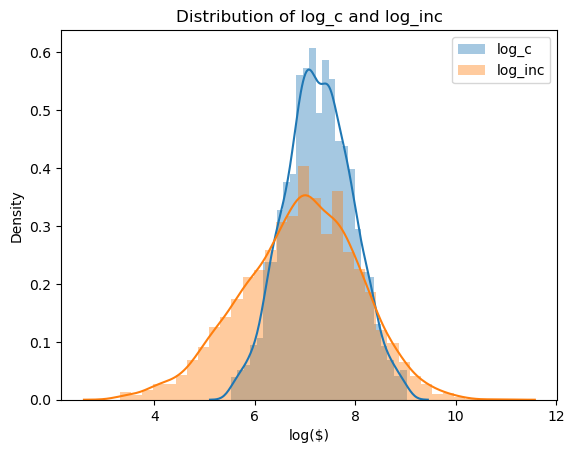

In [28]:
#define variables 
log_c = np.log(df1[['consumption']]) #
log_inc = np.log(df1[['income']]) #
log_w = np.log(df1[['wealth']])

#renaming the columns
log_c.rename(columns={'consumption':'log_c'}, inplace=True)
log_inc.rename(columns={'income':'log_inc'}, inplace=True)
log_w.rename(columns={'wealth':'log_w'}, inplace=True)

#concatenate dataframes
df1 = pd.concat([df1, log_c, log_inc, log_w],axis = 1,join='inner') 


#plotting
fig, ax = plt.subplots()
sns.distplot(log_c, label='log_c')
sns.distplot(log_inc, label='log_inc')
plt.title('Distribution of log_c and log_inc')
ax.legend()
plt.xlabel('log($)')
plt.show()


### 2a 
These distributions are very similar to normal distributions on bell shaped curves. Both the log of consumption and the log of income plotted in the graph take on this normal bell curve shape.

The distribution of log(c) appears symmetrical and unimodal. This implies consumption is fairly equal and evenly distributed.

log(inc) appears to be skewed to the right, implying more values are above the mean (or mean log(inc) is greater than the median, thus showing more inequality.This is refective of the fact that there is a minimum amount of goods that a household can survive on irrespective of income or how much saving is attempted.


### 2b

In [29]:
#variance
l1 = [log_c,log_inc,log_w]
vars = []

for i in l1:
    vars.append(i.var())
    
print(vars)

[log_c    0.445415
dtype: float64, log_inc    1.333515
dtype: float64, log_w    2.659197
dtype: float64]


De Magalhães, L., & Santaeulàlia-Llopis, R. (2018) obtains values of 0.79 for consumption, 0.97 for income, and 2.11 for wealth. Our observations obtained values of:

CONSUMPTION_0.39 (0.79)

INCOME_1.2 (0.97)

WEALTH_2.4 (2.11)

(De Magalhães & Santaeulàlia-Llopis’ USA values in brackets for comparison)

These values would suggest that there is less inequality in consumption in Uganda compared to the USA, but that there is more income and wealth inequality in Uganda. This is likely because of the fact that the lowest salaries in the USA are much higher than the lowest salaries in Uganda.

There appears to be a similar pattern for the relative inequality(i.e log(variance)) of income and wealth. In both sources, relative inequality of wealth is double of income. Lastly, consumptions are both the lowest with coefficients less than 1. 

### 2c

In [30]:
urban_rural = df1[['urban','income','wealth','consumption']].groupby(by='urban').mean()

#rename column 2.0 to female and concatate to df1

urban_rural.rename(index={0: 'rural ', 1: 'urban '}, inplace=True)
print(urban_rural)


             income       wealth  consumption
urban                                        
rural   1712.946899  4517.499962  1626.802569
urban   2454.272682  6699.500230  2520.708577


Both the average incomes and the average consumption is roughly 40 percent higher in urban areas when compared to non-urban areas, the wealth is approximately 10 percent higher. The difference in consumption and income is significant, however the difference in wealth is less large. It is also worth mentioning that these figures are likely higher because the cost of living is higher in cities, with a higher price level compares to rural areas. This means that these significant differences in the figures we have observed may not actually translate to a greatly different standard of living despite appearances looking at the data.

### 2d

In [31]:
urban_rural2 = df1[['urban','log_c','log_inc','log_w']].groupby(by='urban').var()
urban_rural2.rename(index={0: 'rural ', 1: 'urban '}, inplace=True)
print(urban_rural2)


           log_c   log_inc     log_w
urban                               
rural   0.412241  1.339545  2.364454
urban   0.430614  1.098990  3.924767


### 2e 

In [32]:
gini_inputs = ['income', 'wealth', 'consumption']
gini_outputs = []
for i in range(3):
    gini_outputs.append(gini(df1[gini_inputs[i]]))
    print(gini_inputs[i], "Gini coefficient:", gini_outputs[i])



income Gini coefficient: 0.55530958931117
wealth Gini coefficient: 0.6532298295102107
consumption Gini coefficient: 0.3635944084631137


De Magalhães, L., & Santaeulàlia-Llopis, R. (2018) obtains GINI values of 0.41 for consumption, 0.44 for income, and 0.79 for wealth. 

The GINI values we have obtained would suggest that Uganda has more income inequality than the USA (0.51 compared to 0.44), but that the USA has more inequality in both wealth (0.79 compared to 0.59) and consumption (0.41 compared to 0.33)

The Gini coefficient of income and consumption in the USA is almost equal, having a difference of only 0.03, whereas , our results show a bigger difference of 0.2. 


### 2f


In [33]:

#df2 is wealth sorted in ascemnding order 
df2 = df1.sort_values(by='wealth')

#calculate wealth of bottom 50 and total wealth 
b50 = df2['wealth'][:int(len(df2)/2)].sum()
twealth = df2['wealth'].sum()

#share of wealth of b50 
b50_prop = b50/twealth

print('the share of the wealth that the bottom 50 percent hold:', b50_prop, '\n')

#####################################
percentage = [0.1 , 0.05, 0.01]
tpercentile = []
#df3 is wealth sorted in descending order 
df3 = df1.sort_values(by='wealth' ,ascending=False)

for i in range(0,3):
    #wealth of top x% and proportion
    x = df3['wealth'][:int(len(df3) * percentage[i])].sum()
    tx_percent = x/twealth
    tpercentile.append(tx_percent)

    print('the share of the wealth that the top',percentage[i], 'holds is', tpercentile[i])






the share of the wealth that the bottom 50 percent hold: 0.0839841246517288 

the share of the wealth that the top 0.1 holds is 0.5067656546494829
the share of the wealth that the top 0.05 holds is 0.34833749468643194
the share of the wealth that the top 0.01 holds is 0.11097128399552787


### 2g  

Notably, the top 0.01% only has about 0.07 share of wealth, implying inequality might not be as bad as more developed countries such as the USA. However, having a gini coefficient of 0.79 and 0.65(from our findings) is still worrying, indicating high income inequality. While it is worth some caution due to the extent of the informal economy of Uganda, it would seem inequality should be a concern.

Regionally, there is generally quite a large difference in wealth, consumption and income between urban and rural areas. 

However, high variance of log(wealth) indicates even in urban areas inequality may still be high. Whereas, the variance in consumption for both areas are similar. Lastly, the variance of income is starkly lower in urban areas. 



### 2h 


Consumption inequality is not an accurate representation of wealth inequality. Our results have shown it generally underestimates inequality, which can be seen from the distribution density graphs in question 1 and the gini coefficients of consumption being starkly different to wealth and income.


Furthermore, they are also likely to be overestimating the inequality of income , as it is likely that poor Ugandan households rely more on the informal economy, meaning that their consumption likely does not appear officially.

On the other hand they could be underestimating because a large number of poor Ugandans likely live by subsistence, meaning that while their food consumption may appear in figures, they make less recorded income as they do not have to pay for food from formal income.


# Exercise 3 

### 3a,b,c

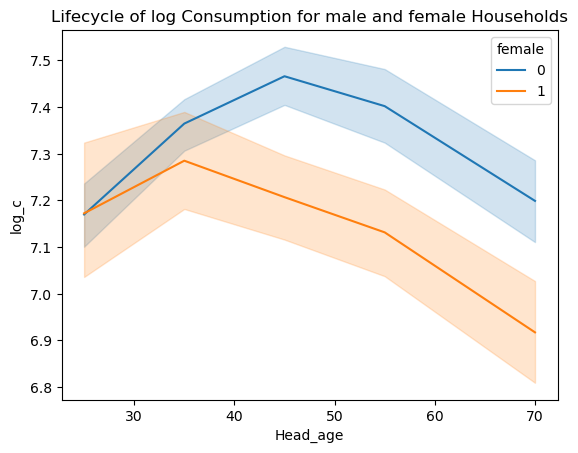

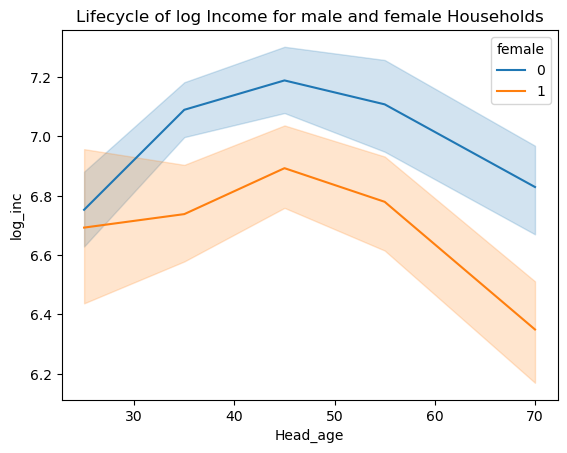

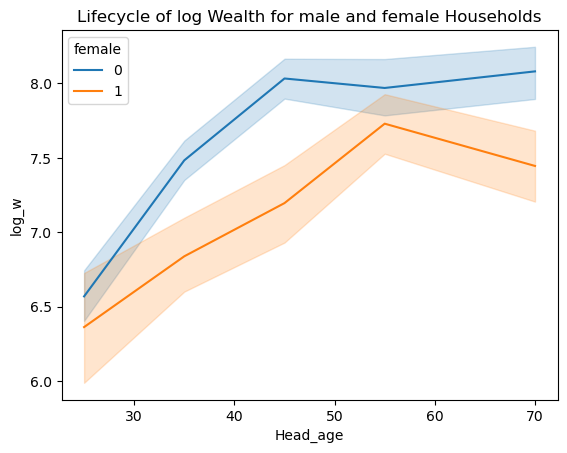

In [34]:
# Drop extreme values (too few observations to get means within age)
df1 = df1[df1['head_age'] < 80]
df1 = df1[df1['head_age'] > 18]

#To smooth the lines, group the ages in bins
bins = [18, 30, 40, 50, 60, 80]
labels = [25, 35, 45, 55, 70]
df1['age_bins'] = pd.cut(df1['head_age'],bins=bins, labels=labels)

#3a
#Then, using seaborn lineplot with the argument hue=’female’,
# or any other variable to distinguish the gender of the head,
#  a. Plot the lifecycle of the log of consumption for households
#  where the head is male and for households where the head is female.

#the  argument is to differentiate between different categories

#plot x =  age , y = log_[i]

l1 = ['log_c','log_inc','log_w']
l2 = ['Lifecycle of log Consumption for male and female Households', 'Lifecycle of log Income for male and female Households', 'Lifecycle of log Wealth for male and female Households']

for i in range(0,3):
    sns.lineplot(x=df1['age_bins'], y=l1[i], hue="female", data=df1)
    plt.title(l2[i])
    plt.xlabel("Head_age")
    plt.ylabel(l1[i])
    plt.show()


### 3d 

When the head of the household is female, the values of income, wealth and consumption are all lower than they are when the head of the household is male, throughout the lifecycle. 


For log consumption, they both exhibit a concave shape with log(consumption) for female heads peaking at ~35 and at ~45 for male heads. Variance for all 3 graphs indicates, females have a higher variance for income, consumption and wealth across their lifecycle than males. 


Income for both groups initially rises, until the household head reaches the age of 45, after which income progressively falls.  Furthermore, there is significantly more variance for females in earlier years than males. 

Wealth increases almost linearly with age for both groups on average until middle age (until approximately age 45 for male led households and until approximately 55 for female led households) indicating stable savings. After this point, wealth remains at approximately the same level, with slight decreases past retirement age for females. 